## Bayesian errors-in-variables estimation of specific climate sensitivity (submitted)
#### D. Heslop, E. J. Rohling, G. L. Foster, and J. Yu

#### Notebook to demonstrate regression via Bayesian EIV estimation (recreates Figure 3).

#### Import require libraries (installation of emcee from here: https://pypi.org/project/emcee/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, uniform
import emcee
import pathos.multiprocessing as mp
from scipy.stats import gaussian_kde

If you have TeX installed these commands will produce LaTeX-formatted plots. If you don't have TeX, then don't execute the commands.

In [2]:
# Enable LaTeX rendering in Matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

Define the functions to find the likelihood, negative loglikelihood, and perform the numerical integration

In [3]:
def loglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims):

    #INPUTS
    #ypts = y-values of regression line at xlims values
    #x_mus = array of data point x-values
    #x_sigmas = array of data point x-value uncertainty standard deviations
    #y_mus = array of data point y-values
    #y_sigmas = array of data point y-value uncertainty standard deviations
    #xlims = x limits for numerical integration 
    
    xpts = np.linspace(xlims[0],xlims[1],len(ypts))     
    p = np.polyfit(xpts,ypts,len(ypts)-1)
    xts = np.linspace(xpts[0],xpts[-1],2000)
    yts = np.polyval(p,xts)
    t = np.sqrt((xts[:-1]-xts[1:])**2+(yts[:-1]-yts[1:])**2)
    
    L = 0    
    for x_mu, x_sigma, y_mu, y_sigma in zip(x_mus,x_sigmas,y_mus,y_sigmas):
        temp = norm.logpdf(xts,loc=x_mu,scale=x_sigma)+norm.logpdf(yts,loc=y_mu,scale=y_sigma)
        Li = log_trapz(temp,t)
        L += Li        

    return L

def negloglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims):
    
    #INPUTS
    #ypts = y-values of regression line at xlims values
    #x_mus = array of data point x-values
    #x_sigmas = array of data point x-value uncertainty standard deviations
    #y_mus = array of data point y-values
    #y_sigmas = array of data point y-value uncertainty standard deviations
    #xlims = x limits for numerical integration 
    
    return -loglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims)

def log_trapz(y,dx):

    #intergrate using trapezoidal rule working in terms of logs
    #INPUTS
    #y = log of input array to integrate
    #dx = spacing between points
    
    n = len(y)
    a = np.max(y)
    ya = np.exp(y-a)    
    temp = (ya[:-1]+ya[1:])/2*dx
    
    return a + np.log(np.sum(temp))

Setup the example model and generate the data

In [4]:
#create "true" data
ptrue = np.array([3.0,0]) #line with gradient = 3 and intercept = 0
n, sigma_x, sigma_y = 50, 0.2, 0.1 # number of data points, x uncertainties and y uncertainties
xlims = np.array([-5,5]) #integration limits for likelihood estimation

np.random.seed(9999) #set for repeatability
fontsize = 14 #plot fontsize
x0 = np.random.rand(n) #collection of x points
y0 = np.polyval(ptrue,x0); #corresponding y-points
    
x_sigmas0 = np.ones(n)*sigma_x #x uncertainties
y_sigmas0 = np.ones(n)*sigma_y #y uncertainties
    
x_mus0 = x0 + np.random.randn(n)*x_sigmas0 #add x-errors to data
y_mus0 = y0 + np.random.randn(n)*y_sigmas0 #add y-errors to data

Fit the OLS and MLE regression models: note ```pNLL0``` is the y-values of the line at ```xlims``` rather than polynomial coefficients

In [5]:
pOLS0 = np.polyfit(x_mus0,y_mus0,1) #OLS model
pNLL0 = minimize(negloglike, np.polyval(pOLS0,xlims), args=(x_mus0, x_sigmas0, y_mus0, y_sigmas0, xlims),method='SLSQP').x #MLE model

Plot the results

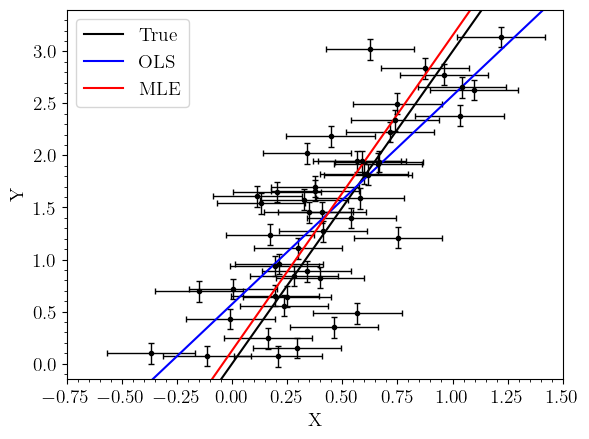

In [6]:
#plot the data
plt.errorbar(x_mus0, y_mus0, xerr=x_sigmas0, yerr=y_sigmas0, fmt='.', color = 'k', ecolor='k', capsize=2,elinewidth=1)
plt.minorticks_on()
plt.xlabel('X',fontsize=fontsize)
plt.ylabel('Y',fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.plot(xlims,np.polyval(ptrue,xlims),'-k',label='True')

plt.plot(xlims,np.polyval(pOLS0,xlims),'-b',label='OLS')
plt.plot(xlims,pNLL0,'-r',label='MLE')

plt.xlim([-0.75,1.5])
plt.ylim([-0.15,3.4])

plt.legend(fontsize=fontsize)

### Use emcee to sample posterior distribution

Set the y-limits at xlims that define the prior on the regression line

In [7]:
ylims = np.array([-30,30])

Define prior as a function, returning the value of the prior for given y end-points of the regression line

In [8]:
def log_prior(ypts,ylims):
    lp = np.sum(uniform.pdf(ypts, loc=ylims[0], scale=ylims[1]))   
    return lp

Define a function that combines the prior with the likelihood (see emcee documentation)

In [9]:
def log_probability(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xpts, ylims):
    
    lp = log_prior(ypts,ylims)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(ypts, x_mus, x_sigmas, y_mus, y_sigmas, xlims)

Setup the emcee initalization based on the MLE solution (see emcee documentation)

In [10]:
pos = pNLL0 + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

Setup and run the sampler (20000 iterations) using multithreading for speed (see emcee documentation

In [11]:
pool = mp.ProcessPool(nodes=16)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, pool = pool, args=(x_mus0, x_sigmas0, y_mus0, y_sigmas0, xlims, ylims))

sampler.run_mcmc(pos, 20000, progress=True);

100%|█████████████████████████████████████| 20000/20000 [16:01<00:00, 20.81it/s]


Arrange the samples into a 2D array, discard the burnin and thinning samples

In [19]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(12160, 2)


The sampler gives distributions of y values at the regression line end-points. Loop through and convert first 10000 samples to polynomial coefficients

In [20]:
flat_samples = flat_samples[0:10000,:]
pMCMC = []
for i in range(flat_samples.shape[0]):
    pMCMC.append(np.polyfit(xlims,flat_samples[i,:],1))
pMCMC = np.asarray(pMCMC)

Loop through the coefficients to find the 95% confidence intervals of the lines as a function of x 

In [21]:
xplot = np.linspace(xlims[0],xlims[-1])
nsamples = np.shape(pMCMC)[0]
temp = np.zeros((nsamples,len(xplot))) 
for i in range(nsamples):
    temp[i,:] = np.polyval(pMCMC[i,:],xplot)
MCMC_CI = np.percentile(temp,[2.5,50,97.5],axis=0).T

### Estimate the OLS fit uncertainty based parametric bootstrapping of x and y uncertainties

In [22]:
niter = 10000 #number of bootstrap iterations
temp = np.zeros((niter,len(xplot)))
pOLS = []
for i in range(niter):
    xi = x_mus0+np.random.randn(len(x_mus0))*x_sigmas0 #add in x-error
    yi = y_mus0+np.random.randn(len(y_mus0))*y_sigmas0 #add in y-error
    p = np.polyfit(xi,yi,1) #fit line
    temp[i,:] = np.polyval(p,xplot) #y-values along line
    pOLS.append(p)

pOLS = np.array(pOLS) #distribution of polynomial coefficients based on bootstrap
OLS_CI = np.percentile(temp,[2.5,50,97.5],axis=0).T #95% confidence interval on line based on bootstrap

### Define function to find the MAP of the posterior distribution using kernel density estimation

In [23]:
def find_MAP(samples):
    kde = gaussian_kde(samples)
    
    # Create an array of values over which to evaluate the KDE
    x_vals = np.linspace(min(samples), max(samples), 1000)
    kde_vals = kde(x_vals)
    
    # Find the peak of the KDE
    map_index = np.argmax(kde_vals)
    return x_vals[map_index]    

### Define function to find the credible interval of a collection of samples

In [24]:
def credible(samples,credible_level):

    # Sort the samples
    sorted_samples = np.sort(samples)
    
    # Determine the credible level and number of samples
    N = len(sorted_samples)
    N_credible = int(credible_level * N)
    
    # Compute the HDR
    intervals = [(sorted_samples[i], sorted_samples[i + N_credible - 1]) for i in range(N - N_credible + 1)]
    ranges = [interval[1] - interval[0] for interval in intervals]
    min_range_index = np.argmin(ranges)
    
    # HDR boundaries
    hdr_interval = intervals[min_range_index]
    
    return np.array(hdr_interval)

### Plot the results

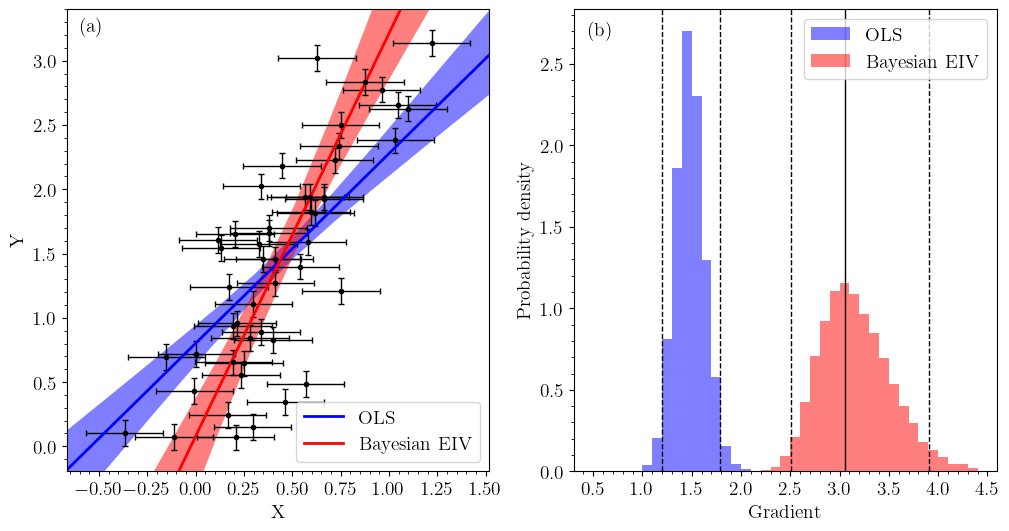

In [25]:
fig = plt.figure(figsize=(12,6))

###### Plot example regression
plt.subplot(1,2,1)
plt.errorbar(x_mus0, y_mus0, xerr=x_sigmas0, yerr=y_sigmas0, fmt='.', color = 'k', ecolor='k', capsize=2,elinewidth=1)
plt.minorticks_on()
plt.xlabel('X',fontsize=fontsize)
plt.ylabel('Y',fontsize=fontsize)

#add reference lines
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.fill_between(xplot,OLS_CI[:,0],y2=OLS_CI[:,2],color='b',alpha=0.5,edgecolor=None)
plt.plot(xplot,OLS_CI[:,1],'b',linewidth=2,label='OLS')

plt.fill_between(xplot,MCMC_CI[:,0],y2=MCMC_CI[:,2],color='r',alpha=0.5,edgecolor=None)
plt.plot(xplot,MCMC_CI[:,1],'r',linewidth=2,label='Bayesian EIV')
plt.text(-0.6,3.225,'(a)',fontsize=fontsize)
plt.legend(fontsize=fontsize,loc='lower right')


###### plot MC histograms
plt.subplot(1,2,2)
bin_edges = np.arange(0.5, 4.5, 0.1)

plt.hist(pOLS[:,0],bins=bin_edges,density=True, alpha = 0.5,color='b', label = "OLS");
plt.hist(pMCMC[:,0],bins=bin_edges,density=True, alpha = 0.5,color='r', label = "Bayesian EIV");
plt.minorticks_on()
plt.xlabel('Gradient',fontsize=fontsize)
plt.ylabel('Probability density',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().axvline(x=np.percentile(pOLS[:,0],2.5), color='k', linestyle='--', linewidth=1)
plt.gca().axvline(x=np.percentile(pOLS[:,0],97.5), color='k', linestyle='--', linewidth=1)

CI = credible(pMCMC[:,0],0.95)
plt.gca().axvline(x=CI[0], color='k', linestyle='--', linewidth=1)
plt.gca().axvline(x=CI[1], color='k', linestyle='--', linewidth=1)
plt.gca().axvline(x=find_MAP(pMCMC[:,0]), color='k', linestyle='-', linewidth=1)

plt.text(0.45,2.675,'(b)',fontsize=fontsize)
plt.legend(fontsize=fontsize);